# Multi-User ReAct AI Agent Chatbot in LangGraph - Pre-Built Agents
* Notebook by Adam Lang
* Date: 10/4/2024

# Overview
* We will build a Multi-user ReAct AI Agent Chatbot using LangGraph.
* We will use the following framework which includes 2 tools:
1. Weather API
2. Tavily Search API
* We will use GPT-4o as the LLM.
* We will store the user conversation in memory.
* An example of what we are doing:
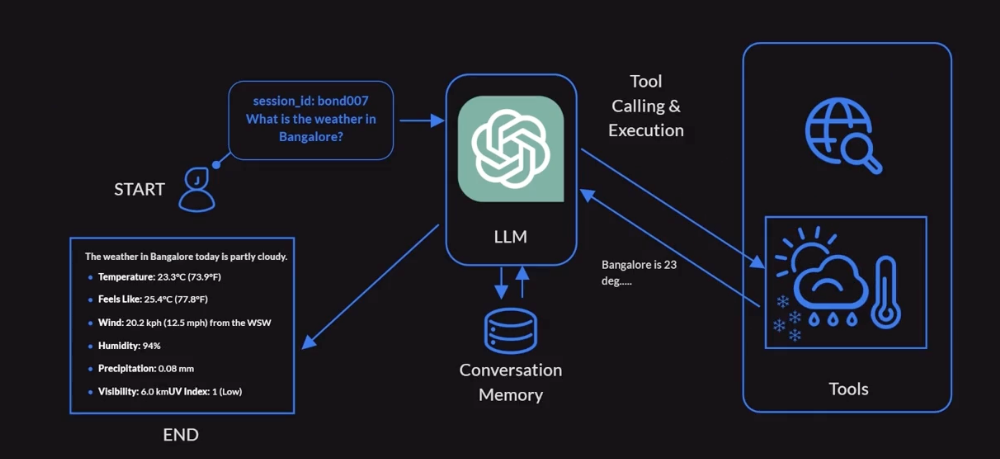

## Workflow
* We will use a pre-built agent from LangGraph.
* This app will use a simple ReAct agent that can search the web and check the weather.
* The app will consist of an LLM and Tools.
* A user interacts with the app and it does the following:
1. Calls agent (LLM) to decide if we need Tools.
2. Then we run a loop:
  * If agent said to take action (e.g. call Tool), we run tools and pass results back to agent.
  * If agent did not ask to run tools, we finish and respond to user.

# Install Dependencies

In [1]:
!pip install langchain==0.2.0
!pip install langchain-openai==0.1.7
!pip install langchain-community==0.2.0
!pip install langgraph==0.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 886.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.0/397.0 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3

## Enter OpenAI API key

In [2]:
from getpass import getpass

OPENAI_KEY = getpass('Enter your OpenAI API key: ')

Enter your OpenAI API key: ··········


## Enter Tavily Search API Key

In [3]:
TAVILY_API_KEY = getpass('Enter Tavily Search API Key: ')

Enter Tavily Search API Key: ··········


## Enter WeatherAPI API Key

In [4]:
WEATHER_API_KEY = getpass('Enter WeatherAPI API Key: ')

Enter WeatherAPI API Key: ··········


## Setup Environment Variables

In [5]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

# Create Tools
* We start by creating the 2 custom tools for the LLM to access:
1. Simple Web Search Tool with Tavily API
2. Weather Tool with WeatherAPI

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults ##Tavily api
from langchain_core.tools import tool ## tools
import json
import requests

## instantiate tv_search
tv_search = TavilySearchResults(max_results=3,
                                search_depth='advanced',
                                max_tokens=10000)


# search tool
@tool
def search_web(query: str) -> list:
  """Tool to search web for query result."""
  tavily_tool = TavilySearchResults(max_results=2)
  results = tavily_tool.invoke(query)
  return results

# weather tool
@tool
def get_weather(query: str) -> list:
  """Tool to search weatherapi for current weather."""
  base_url = "https://api.weatherapi.com/v1/current.json"
  complete_url = f"{base_url}?key={WEATHER_API_KEY}&q={query}"

  ## requests from api
  response = requests.get(complete_url)
  data = response.json()
  if data.get('location'):
    return data
  else:
    return "Weather Data Not Found"

# Test Tool Calling with LLM

In [7]:
from langchain_openai import ChatOpenAI

## llm
chatgpt = ChatOpenAI(model='gpt-4o', temperature=0)
## create tools variable
tools = [search_web, get_weather]

## bind_tools to llm
chatgpt_with_tools = chatgpt.bind_tools(tools)

In [22]:
## test prompt
prompt = "Who won the Super Bowl in 2024"
response = chatgpt_with_tools.invoke(prompt)
response.tool_calls

[{'name': 'search_web',
  'args': {'query': 'Super Bowl 2024 winner'},
  'id': 'call_zr3bHK6sVVrDVrzfbnJOQ3I6',
  'type': 'tool_call'}]

In [23]:
## test prompt
prompt = "how is the weather in Denver, CO today?"
response = chatgpt_with_tools.invoke(prompt)
response.tool_calls

[{'name': 'get_weather',
  'args': {'query': 'Denver, CO'},
  'id': 'call_IiPyW6ZCIXKpUJFMJmXUdFpV',
  'type': 'tool_call'}]

# Build and Test AI Agent with LangGraph Pre-built Agent
* Now we can create our Agent.
* We will use the tool calling agent to bind tools to the agent with a prompt.
* We will also add capability to store historical conversations as memory for the chatbot.

In [24]:
## imports
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

## system prompt
SYS_PROMPT = """Act as a helpful assistant.
                Use the tools at your disposal to perform tasks as needed.
                  - get_weather: whenever user asks get the weather of a place.
                  - search_web: whenever user asks for information on current events or if you don't know the answer.
             """
## prompt template
prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", SYS_PROMPT),
        MessagesPlaceholder(variable_name='messages')

    ]
)

## LangGraph does not suppor system prompts so we need to add a function for it
def add_sys_prompt(messages):
  """Converts prompt_template to list of messages"""
  return prompt_template.invoke({"messages": messages}).to_messages()


Now we can do the following:
1. init agent with LLM, system prompt and tools.
2. LangGraph will help us create a ReAct style agent with built-in `create_react_agent` function. We are using a pre-built agent.
3. LangGraph allows you to create your own agent infrastructure.

Note: Passing in the model `chatgpt` not `chatgpt_with_tools`.
  * This is because LangGraph will automatically bind the tools under the hood using the `bind_tools` function.
  * This should ideally be used with an LLM which supports tool/function calling.

In [25]:
## prebuilt langgraph agent
from langgraph.prebuilt import create_react_agent

## init agent
agent = create_react_agent(chatgpt,
                           tools=tools,
                           messages_modifier=add_sys_prompt)

## Visualize Agent architecture

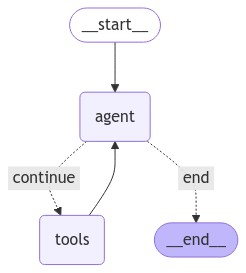

In [26]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

In [27]:
## query
query = """Tell me who won the Super Bowl in 2024,
           show me some detailed information about the games.
        """
response = chatgpt.invoke(query)
response.content

"I'm sorry, but I don't have access to real-time data or events occurring after October 2023. To find out who won the Super Bowl in 2024 and get detailed information about the game, I recommend checking the latest sports news websites, the NFL's official website, or other reliable sources for up-to-date information."

Summary:
* AHA! We can see the issue here is that ChatGPT was last trained in October 2023 so it is missing this data from February 2024.
* Now lets use our agent.

In [28]:
## query with agent
query = """Tell me who won the Super Bowl in 2024,
            show me some detailed information about the games.
        """

response = agent.invoke({"messages": [('user', query)]})

In [29]:
## response with agent
response

{'messages': [HumanMessage(content='Tell me who won the Super Bowl in 2024,\n            show me some detailed information about the games.\n        ', id='a7ff0b1a-e628-481a-b3ff-fbe69c4b841d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_JtnzCUPOc7uhsJfarNC7v2Aw', 'function': {'arguments': '{"query":"Super Bowl 2024 winner and game details"}', 'name': 'search_web'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 148, 'total_tokens': 170, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_2f406b9113', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-108078ed-78fa-4291-9b42-4b9e7f0cb165-0', tool_calls=[{'name': 'search_web', 'args': {'query': 'Super Bowl 2024 winner and game details'}, 'id': 'call_JtnzCUPOc7uhsJfarNC7v2Aw', 'type': 'tool_call'}]),
  ToolMe

In [30]:
## display markdown result
from IPython.display import display, Markdown

## display markdown
display(Markdown(response['messages'][-1].content))

The Kansas City Chiefs won the Super Bowl in 2024, defeating the San Francisco 49ers with a score of 25-22 in overtime. This victory marked the Chiefs' third Super Bowl win in five years and their second consecutive title, making them the ninth team to repeat as Super Bowl champions.

### Game Highlights:
- **Quarterback Performance**: Patrick Mahomes, the Chiefs' star quarterback, played a crucial role in the victory. He threw the game-winning touchdown pass to wide receiver Mecole Hardman Jr. during overtime.
- **Key Plays**: The game was tied late in the fourth quarter, but a strategic blitz by the Chiefs' defense forced the 49ers to settle for a field goal. This set the stage for Mahomes' heroics in overtime.
- **49ers' Efforts**: San Francisco's running back, Christian McCaffrey, scored a touchdown during the first half, contributing to the 49ers' competitive performance.
- **Venue**: The game took place at Allegiant Stadium in Las Vegas.

The Chiefs embraced an underdog mentality throughout the postseason, overcoming several challenges to secure their victory.

In [32]:
## weather query
query = """how is the weather in Denver, CO today?
        """
response = agent.invoke({"messages": [('user', query)]})

In [33]:
## display markdown
display(Markdown(response['messages'][-1].content))

The weather in Denver, CO today is sunny with a temperature of 30.0°C (86.1°F). The wind is coming from the east at 2.9 mph (4.7 kph). The humidity is quite low at 14%, and there is no precipitation. The UV index is 8, indicating a high level of UV radiation, so it's a good idea to wear sunscreen if you're going outside. Visibility is 10 km (6 miles).

In [34]:
## testing the conversational agent
query = """What have we discussed so far?
        """

response = agent.invoke({"messages": [('user', query)]})

In [35]:
## display output
display(Markdown(response['messages'][-1].content))

We haven't had any prior discussions in this session. If you have any questions or need assistance, feel free to ask!

Summary:
* The agent is doing well finding the answers to our queries but we can see that it does not have the ability to recall or remember conversations yet.
* We need to add memory storage for the chatbot to do this.

# Build and Test Multi-User Conversational ReAct AI Agent
* We will now use a simple `SqliteSaver` which helps us store separate conversation histories per user per session.
* This will help us build a conversational Agentic Chatbot which will be accessed by many users at the same time.
* While the legacy syntax uses `session_id` in LangGraph, each user session is identified by `thread_id`.

In [36]:
## removes memory database file - usually not needed
# you can run this only when you need to remove ALL CONVERSATION history
# ok if you get rm: cannot remove 'memory.db': No such file or directory because initially no memory exists
!rm memory.db*

rm: cannot remove 'memory.db*': No such file or directory


In [38]:
## import SqliteSaver
from langgraph.checkpoint.sqlite import SqliteSaver

## used to retrieve conversation history from database
## based on specific user or session ID
memory = SqliteSaver.from_conn_string('memory.db')

## create conversation chain + agent which can load memory based on specific user or session id
agentic_chatbot = create_react_agent(chatgpt,
                                     tools=tools,
                                     checkpointer=memory,
                                     messages_modifier=add_sys_prompt)

# function to call agent to show results per user session (called a thread ID here)
from IPython.display import display, Markdown

def chat_with_agent(prompt: str, session_id: str):
  response = agentic_chatbot.invoke({"messages": [('user', prompt)]},
                                    {'configurable': { 'thread_id': session_id}})
  ## show content from last message in graph state
  display(Markdown(response['messages'][-1].content))

## Simulate User 1 using agent

In [39]:
user_id = "tom007"
prompt = "Tell me who won the Super Bowl in 2024"
chat_with_agent(prompt, user_id)

The Kansas City Chiefs won the Super Bowl in 2024, defeating the San Francisco 49ers 25-22 in overtime.

In [40]:
## follow up question
prompt = "Tell me more about this event in detail please. Who is the coach of the winning team?"
chat_with_agent(prompt, user_id)

The Kansas City Chiefs won the Super Bowl in 2024 with a thrilling 25-22 overtime victory against the San Francisco 49ers. This victory marked the Chiefs' third Super Bowl win in five years and their second consecutive title, making them the ninth team to repeat as Super Bowl champions.

The game was held at Allegiant Stadium in Las Vegas. The Chiefs' star quarterback, Patrick Mahomes, played a crucial role in the victory, including throwing the game-winning touchdown pass to wide receiver Mecole Hardman Jr. during overtime. The Chiefs' defense, led by defensive coordinator Steve Spagnuolo, made key plays, including a critical blitz late in the fourth quarter that forced a 49ers field goal.

The head coach of the Kansas City Chiefs during this victory was Andy Reid. Under his leadership, the team embraced an underdog mentality throughout the postseason, overcoming challenges and upsetting three teams on their way to the championship.

In [42]:
## follow up question
prompt = "Who was the musical performer that day"
chat_with_agent(prompt, user_id)

The musical performer for the Super Bowl 2024 halftime show was Usher. He headlined the event, delivering a stellar performance featuring some of his biggest hits like "Yeah!," "Burn," "U Got It Bad," "My Boo," and "Confessions Part II."

In addition to Usher's halftime performance, the pregame festivities included performances by Reba McEntire, who sang the national anthem, Post Malone, who performed "America the Beautiful," and Andra Day, who sang "Lift Every Voice and Sing."

## Simulate User 2 using agent

In [43]:
user_id = 'taylor1989'
prompt = "how is the weather in Miami today? Show detailed statistics."
chat_with_agent(prompt, user_id)

The weather in Miami today is partly cloudy. Here are the detailed statistics:

- **Temperature**: 29.4°C (84.9°F)
- **Feels Like**: 33.5°C (92.3°F)
- **Wind**: East at 12.8 mph (20.5 kph)
- **Wind Gusts**: Up to 14.7 mph (23.6 kph)
- **Humidity**: 80%
- **Pressure**: 1015.0 mb (29.96 in)
- **Precipitation**: 0.0 mm (0.0 in)
- **Cloud Cover**: 75%
- **Visibility**: 16.0 km (9.0 miles)
- **UV Index**: 8.0
- **Dew Point**: 23.9°C (75.0°F)

The weather is warm and humid, with a moderate UV index, so it's a good idea to wear sunscreen if you're spending time outdoors.

In [44]:
## another question same user
user_id = 'taylor1989'
prompt = "what about Phoenix?"
chat_with_agent(prompt, user_id)

The weather in Phoenix today is partly cloudy. Here are the detailed statistics:

- **Temperature**: 39.4°C (102.9°F)
- **Feels Like**: 39.0°C (102.3°F)
- **Wind**: East-Southeast at 2.2 mph (3.6 kph)
- **Wind Gusts**: Up to 2.6 mph (4.1 kph)
- **Humidity**: 10%
- **Pressure**: 1012.0 mb (29.87 in)
- **Precipitation**: 0.0 mm (0.0 in)
- **Cloud Cover**: 25%
- **Visibility**: 16.0 km (9.0 miles)
- **UV Index**: 9.0
- **Dew Point**: 4.1°C (39.4°F)

The weather is very hot and dry, with a high UV index, so it's important to stay hydrated and protect yourself from the sun if you're outdoors.

In [45]:
## follow up question
user_id = 'taylor1989'
prompt = 'which city is hotter?'
chat_with_agent(prompt, user_id)

Phoenix is hotter than Miami today. The temperature in Phoenix is 39.4°C (102.9°F), while in Miami, it is 29.4°C (84.9°F).

In [47]:
## follow up question
user_id = 'taylor1989'
prompt = "which city is hotter"
chat_with_agent(prompt, user_id)

Phoenix is hotter than Miami today. The temperature in Phoenix is 39.4°C (102.9°F), while in Miami, it is 29.4°C (84.9°F).